## Import

In [1]:
import h5py
import os
import numpy as np
from tensorflow.keras.models import load_model

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import (accuracy_score, f1_score, roc_curve, roc_auc_score, precision_score, 
                             recall_score, confusion_matrix, precision_recall_curve, auc, 
                             average_precision_score)
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.feature_selection import mutual_info_classif
from scipy.spatial.distance import pdist, squareform
from scipy.stats import ttest_ind
from xgboost import XGBClassifier

from tensorflow.keras.layers import (GlobalAveragePooling2D, BatchNormalization, Input, Conv2D, 
                                     MaxPooling2D, UpSampling2D, Dense, Reshape, Flatten, Dropout)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier, VotingClassifier


## caricamento dati

In [3]:

file_path = "../CSV/data_rad_clin_DEF.csv"

data = pd.read_csv(file_path)
labels_column = data['label']
labels = labels_column.astype(int).tolist()

labels=np.array(labels)

# Estrazione dei numeri dai nomi dei pazienti
loaded_patients = data['IDs_new'].str.extract(r'(\d+)').astype(int).squeeze().tolist()

print("Labels:", labels)
print("Number of labels:", len(labels))
print("Patient Names: ", loaded_patients )


h5_file_path = '../images_by_patient_final.h5'
loaded_class_images=[]

with h5py.File(h5_file_path, 'r') as h5_file:
    loaded_class_images = {key: np.array(h5_file[key]) for key in h5_file.keys()}

loaded_class_images= {int(key.split('_')[1]): images for key, images in loaded_class_images.items()}

print("Lunghezza array immagini: ", len(loaded_class_images))
print("Shape immagini primo paziente: ", loaded_class_images[0].shape)
print("Shape immagini secondo paziente: ", loaded_class_images[1].shape)




Labels: [0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0
 0 0 1 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0
 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1]
Number of labels: 129
Patient Names:  [5, 12, 15, 16, 17, 19, 22, 23, 24, 25, 26, 27, 29, 30, 31, 33, 35, 36, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 50, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 64, 65, 68, 69, 70, 71, 74, 75, 76, 78, 79, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 98, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 123, 124, 126, 127, 128, 129, 133, 135, 136, 137, 138, 139, 141, 142, 144, 146, 147, 149, 150, 153, 155, 158, 159, 161, 163, 166, 168, 169, 170, 171, 175, 176, 178, 182, 183, 188, 189, 190, 193, 197, 199, 200, 205]
Lunghezza array immagini:  129
Shape immagini primo paziente:  (28, 64, 64)
Shape immagini secondo paziente:  (

In [4]:
file_path = "../CSV/VGG19_ALL_SLICES.csv"

data = pd.read_csv(file_path)


patients = []

for patient_id in loaded_patients:

    patient_data = data[data['Patient'] == patient_id]
    
    slices = []
    
    for _, slice_row in patient_data.iterrows():
        slice_features = slice_row.iloc[2:].tolist()
        slices.append(slice_features)
    

    patients.append(slices)


## funzioni

In [20]:
## funzione per creare array da array di array
def continue_array(filtered_patients, labels):
    all_features = []
    for patient in filtered_patients:
        for image_features in patient:
            all_features.append(image_features)

    all_features_array = np.array(all_features)
    expanded_labels = []
    expanded_patient_ids = []

    for i in range(len(filtered_patients)):
        num_images = len(filtered_patients[i])
        expanded_labels.extend([labels[i]] * num_images)
        expanded_patient_ids.extend([loaded_patients[i]] * num_images)

    expanded_labels_array = np.array(expanded_labels)
    expanded_patient_ids_array = np.array(expanded_patient_ids)

    return all_features_array, expanded_labels_array, expanded_patient_ids_array


## funzioni per feature correlation
def filter_highly_correlated_features(df, corr, threshold=0.85):
    columns = np.full((corr.shape[0],), True, dtype=bool)
    removed_features = []

    for i in range(corr.shape[0]):
        for j in range(i + 1, corr.shape[0]):
            if corr.iloc[i, j] >= threshold:
                if columns[j]:
                    columns[j] = False
                    removed_features.append(df.columns[j])

    return removed_features


def perform_correlation(z_train, y_train, numero = 32, threshold = 0.85):
    all_images, _, _= continue_array(z_train, y_train)

    df = pd.DataFrame(all_images, columns=[f'feature_{i}' for i in range(numero)])

    corr_matrix = df.corr()

    features_selected = filter_highly_correlated_features(df, corr_matrix, threshold)
    
    return features_selected

## funzione per rimuovere le features con p_value maggiore della treshold
def select_features_by_p_value(x_train_expanded, y_train_expanded, p_value_threshold=0.05):

    p_values = []
    num_features = x_train_expanded.shape[1]

    for i in range(num_features):
        feature = x_train_expanded[:, i]
        group_0 = feature[y_train_expanded == 0]
        group_1 = feature[y_train_expanded == 1]
        t_stat, p_val = ttest_ind(group_0, group_1, equal_var=False)
        p_values.append(p_val)

    p_values = np.array(p_values)

    selected_features_indices = np.where(p_values < p_value_threshold)[0]

    sorted_indices = selected_features_indices[np.argsort(p_values[selected_features_indices])]

    x_train_expanded = x_train_expanded[:, sorted_indices]

    return x_train_expanded, sorted_indices



## funzione per rimozione di features specifiche
def remove_features_from_patients(patients, features_to_remove):
    feature_indices_to_remove = [int(feature.split('_')[1]) for feature in features_to_remove]
    
    final_patients = []
    for patient in patients:
        new_patients = []
        for image_features in patient:
            new_patient = np.delete(image_features, feature_indices_to_remove, axis=0)
            new_patients.append(new_patient)
        final_patients.append(np.array(new_patients))    

    return final_patients


## FEATURE SELECTION LASSO
def select_features_with_lasso(X, y, alpha=0.001):
    
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    coefficients = lasso.coef_
    selected_features = np.where(coefficients != 0)[0]
    X_selected = X[:, selected_features]

    return X_selected, selected_features

## FEATURE SELECTION LOGISTIC
def logistic_regression_feature_selection(X, y, num_features):
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X, y)
    coef_abs = np.abs(lr.coef_)
    feature_importances = np.mean(coef_abs, axis=0)
    selected_features = feature_importances.argsort()[-num_features:][::-1]
    X_selected = X[:, selected_features]
    return X_selected, selected_features

## FEATURE SELECTION MRMR
def mrmr_feature_selection(X, y, num_features):
    mi = mutual_info_classif(X, y, random_state=42)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    distances = squareform(pdist(X_scaled.T, 'euclidean'))
    
    selected_features = []
    selected_indices = []

    first_feature_index = np.argmax(mi)
    selected_features.append(first_feature_index)
    selected_indices.append(first_feature_index)
    
    for _ in range(num_features - 1):
        max_relevance = -np.inf
        selected_feature_index = -1
        
        for i in range(X.shape[1]):
            if i in selected_indices:
                continue
            
            relevance = mi[i]
            redundancy = np.mean(distances[i, selected_indices])
            
            mrmr_score = relevance - redundancy
            
            if mrmr_score > max_relevance:
                max_relevance = mrmr_score
                selected_feature_index = i
        
        selected_features.append(selected_feature_index)
        selected_indices.append(selected_feature_index)

    X_selected = X[:, selected_indices]
    return X_selected, selected_indices

## FEATURE SELECTION RANDOM FOREST
def rf_feature_selection(X, y, num_features):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    feature_importances = rf.feature_importances_
    selected_features = np.argsort(feature_importances)[-num_features:][::-1]
    X_selected = X[:, selected_features]
    return X_selected, selected_features


## FEATURE SELECTION P_VALUE
# Seleziona e ordina le feature basate sui p-value con un test t di Student poi 
# ordina le feature in base al p-value in ordine crescente e seleziona le prime `num_features` caratteristiche.

def p_value_feature_selection(x_train_expanded, y_train_expanded, num_features):
    p_values = []
    num_features_total = x_train_expanded.shape[1]

    # Calcolo dei p-value per ciascuna feature
    for i in range(num_features_total):
        feature = x_train_expanded[:, i]
        group_0 = feature[y_train_expanded == 0]
        group_1 = feature[y_train_expanded == 1]
        t_stat, p_val = ttest_ind(group_0, group_1, equal_var=False)
        p_values.append(p_val)


    p_values = np.array(p_values)

    # Ordinare tutte le caratteristiche in base ai p-value (dal più piccolo al più grande)
    sorted_indices = np.argsort(p_values)
    sorted_indices = sorted_indices[:num_features]

    x_train_selected = x_train_expanded[:, sorted_indices]

    return x_train_selected, sorted_indices



## funzione per lasciare solo le features indicate per array di array
def keep_features_in_patients(patients, features_to_keep):

    feature_indices_to_keep = [int(feature) for feature in features_to_keep]

    final_patients = []
    for patient in patients:
        new_patients = []
        for image_features in patient:
            new_patient = np.take(image_features, feature_indices_to_keep, axis=0)
            new_patients.append(new_patient)
        final_patients.append(np.array(new_patients))

    return final_patients


## funzione per lasciare solo le features indicate per array
def filter_patients_features(filtered_patients, selected_features):

    filtered_patients_selected = []

    for patient_features in filtered_patients:
        # Select only the features specified in selected_features
        patient_features_selected = patient_features[:, selected_features]
        filtered_patients_selected.append(patient_features_selected)

    return filtered_patients_selected




In [21]:

## funzione per effettuarr majority voting o mean su tutte le slice di un paziente, per passare da una predizione sulla slice
## alla predizione per il paziente
def prob_to_binary(predictions_proba, patient_scores, threshold, mode):
        final_predictionarray=[]          
        if(mode=='MV'): ## majority voting
            for p in predictions_proba:
                test_patient_predictions=[]
                for proba in p:               
                    predictions_binary = 1 if proba[0][1] > threshold else 0
                    test_patient_predictions.append(predictions_binary)
                count_0 = np.sum(np.array(test_patient_predictions)==0) 
                count_1 = np.sum(np.array(test_patient_predictions)==1)                                   
                final_prediction = 0 if count_0 > count_1 else 1
                final_predictionarray.append(final_prediction)
        
        elif (mode=='Mean'): ## mean
            for score in patient_scores:
                predictions_binary = 1 if score > threshold else 0
                final_predictionarray.append(predictions_binary)    
    
        return final_predictionarray


def classification_method(selector, alpha, classifier, x_train_expanded, y_train_expanded, patients_test, y_test, features_test, num_features, modePrediction, thresholds=np.arange(0.001, 0.501, 0.001), mode = "Val", selected_features= [0]):

    if(mode == "Val"):
            selected_features = None 
            
            if num_features != len(x_train_expanded[0]) or alpha != 0:
                if selector == "lasso":
                    X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
                elif selector == "logistic": 
                    X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
                elif selector == "mrmr":
                    X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
                elif selector == "rf":
                    X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
                elif selector=="p_value":
                    X_selected, selected_features= p_value_feature_selection(x_train_expanded,y_train_expanded, num_features)
                else:
                    print("Wrong selector. Choose between: mrmr, rf, logistic, p_value, lasso")
                    return
                
                features_test = filter_patients_features(features_test, selected_features)
            else:
                X_selected = x_train_expanded
                selected_features = list(range(len(x_train_expanded[0])))  # Selezioniamo tutte le feature se non si fa feature selection
            number_features = len(selected_features) 
        
            smote = SMOTE(random_state=42)
            #adasyn = ADASYN(random_state=42)

            X_resampled, y_resampled = smote.fit_resample(X_selected, y_train_expanded)
            classifier.fit(X_resampled, y_resampled)
   
    if (mode == "Test"): ## non si effettua nuovamente il training e la feature selection
        features_test = filter_patients_features(features_test, selected_features)
        number_features = len(selected_features)

  
    temp_array = []
    patient_scores = []
    
    for x in range(len(patients_test)):
        patient_predictions = []
        patient_predictions1 = []
        r=len(features_test[x])
        for i in range(r):
            dato = features_test[x][i].reshape(1, -1)
            prediction = classifier.predict_proba(dato)
            prediction1 = classifier.predict_proba(dato)[:,1]
            patient_predictions.append(prediction)
            patient_predictions1.append(prediction1)
            mean=np.mean(patient_predictions1)

        patient_scores.append(mean) ## contiene la media delle probabilità
        temp_array.append(patient_predictions) ## contiene tutte le probabilità
        
    best_f1_score = 0
    best_threshold = None
    best_precision=0
    best_recall=0
    best_prediction=[]
    
    # Valuta le performance utilizzando diverse threshold
    if isinstance(thresholds, (int, float, complex)):
        thresholds=[thresholds]

    ## se non viene specificato usi il parametro di default 
    ## viene calcolata la threshold che porta a un f1 migliore e effettuata la prediction con quella
    if(len(thresholds)!=1):
        for threshold in thresholds:
            binary_predictions = prob_to_binary(temp_array, patient_scores, threshold, modePrediction)
            f1 = f1_score(y_test, binary_predictions)
            if f1 > best_f1_score:
                best_f1_score = f1
                best_threshold = threshold
                best_precision = precision_score(y_test, binary_predictions)
                best_recall = recall_score(y_test, binary_predictions)
                best_prediction=binary_predictions

    else: ## qui vuol dire che è il set di test che usa la threshold migliore che viene passata dal validation
        best_threshold = thresholds
        best_prediction=prob_to_binary(temp_array, patient_scores, best_threshold, modePrediction)
        best_f1_score = f1_score(y_test, best_prediction)
        best_precision = precision_score(y_test, best_prediction)
        best_recall = recall_score(y_test, best_prediction)

    #print(f"La migliore threshold è {best_threshold} con f1score di {best_f1_score} e precision {best_precision} e recall {best_recall}.")
    y_test= np.array(y_test)
    best_prediction=np.array(best_prediction)
    test_accuracy = accuracy_score(y_test, best_prediction)

    precision, recall, _ = precision_recall_curve(y_test, patient_scores) ## utili per ricostruire grafici
    pr_auc = average_precision_score(y_test, patient_scores)

    #fpr, tpr, _ = roc_curve(y_test, best_prediction)
    roc_auc= roc_auc_score(y_test, patient_scores)


    conf= confusion_matrix(y_test, best_prediction)
    return best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, best_threshold, number_features, selected_features, classifier



## questa funzione è da utilizzare quando si fa il training sul test e gli vengono già passate le features, quindi non viene effettuata feature selection
## ma solo allenamento del classificatore

def classification_method_test_intero(classifier, x_train_expanded, y_train_expanded, patients_test, y_test, features_test, thresholds, mode):
       
    smote = SMOTE(random_state=42)
    #adasyn = ADASYN(random_state=42)


    X_resampled, y_resampled = smote.fit_resample(x_train_expanded, y_train_expanded)
    #X_resampled, y_resampled = adasyn.fit_resample(x_train_expanded, y_train_expanded)
    classifier.fit(X_resampled, y_resampled)


    temp_array = []
    patient_scores = []
    
    for x in range(len(patients_test)):
        patient_predictions = []
        patient_predictions1 = []
        r=len(features_test[x])
        for i in range(r):
            dato = features_test[x][i].reshape(1, -1)
            prediction = classifier.predict_proba(dato)
            prediction1 = classifier.predict_proba(dato)[:,1]
            patient_predictions.append(prediction)
            patient_predictions1.append(prediction1)
            mean=np.mean(patient_predictions1)

        patient_scores.append(mean) ## contiene la media delle probabilità
        temp_array.append(patient_predictions) ## contiene tutte le probabilità


    best_f1_score = 0
    best_threshold = None
    best_precision=0
    best_recall=0
    best_prediction=[]
 
    if isinstance(thresholds, (int, float, complex)):
        thresholds=[thresholds]

    best_threshold = thresholds
    best_prediction=prob_to_binary(temp_array, patient_scores, best_threshold, mode)
    best_f1_score = f1_score(y_test, best_prediction)
    best_precision = precision_score(y_test, best_prediction)
    best_recall = recall_score(y_test, best_prediction)

    y_test= np.array(y_test)
    best_prediction=np.array(best_prediction)
    test_accuracy = accuracy_score(y_test, best_prediction)


    conf= confusion_matrix(y_test, best_prediction)
    return best_f1_score, best_precision, best_recall, conf, test_accuracy



## split

In [72]:

# patients_train contiene il nome dei pazienti (5,12 etc)
# y_train contiene le labels
# features_train contiene array di array dove ogni paziente ha varie immagini rappresentate da n features

patients_train1, patients_test, y_train1, y_test, features_train1, features_test= train_test_split(loaded_patients, labels, patients, test_size=0.3, shuffle=False, random_state=1)
patients_train, patients_val, y_train, y_val, features_train, features_val= train_test_split(patients_train1, y_train1, features_train1, test_size=0.3, shuffle=True, stratify=y_train1, random_state=3)
#patients_train, patients_val, y_train, y_val, features_train, features_val= train_test_split(patients_train1, y_train1, features_train1, test_size=0.15, shuffle=False, random_state=1)

print("Number of train patients: ", len(features_train))
print("Number of test patients: ", len(features_test))
print("Number of val patients: ", len(features_val))

print("Number of features for every image: ", len(features_train[0][0]) )


Number of train patients:  63
Number of test patients:  39
Number of val patients:  27
Number of features for every image:  512


In [73]:
alpha_values = np.linspace(0, 0.006, 30).tolist()

selectors=['p_value', 'mrmr','rf', 'logistic', 'lasso']
classifiers=['RandomForest', 'Logistic', 'XgBoost', 'MLP', 'SVM', 'ensemble']
modes=['Mean', 'MV']

In [74]:
starting_features = len(features_train[0][0])
features=perform_correlation(features_train, y_train, starting_features, 0.8)

final_patients_train=remove_features_from_patients(features_train, features)
final_patients_test=remove_features_from_patients(features_test, features)
final_patients_val=remove_features_from_patients(features_val, features)
final_patients_train1=remove_features_from_patients(features_train1, features)

x_train_expanded, y_train_expanded, _ = continue_array(final_patients_train, y_train)
x_train_expanded, sf= select_features_by_p_value(x_train_expanded, y_train_expanded, 0.01)
print("x_train_expanded", x_train_expanded.shape)


final_patients_test=keep_features_in_patients(final_patients_test, sf)
final_patients_val=keep_features_in_patients(final_patients_val, sf)
final_patients_train1=keep_features_in_patients(final_patients_train1, sf)
print("final_patients_val", final_patients_val[0].shape)
print("final_patients_test", final_patients_test[0].shape)
print("final_patients_train1", final_patients_train1[0].shape)
print(f"Scelte {len(sf)} features\n")


x_train_expanded1, y_train_expanded1, _ = continue_array(final_patients_train1, y_train1)
print("x_train_expanded1", x_train_expanded1.shape)

x_train_expanded (2698, 356)
final_patients_val (41, 356)
final_patients_test (43, 356)
final_patients_train1 (41, 356)
Scelte 356 features

[183 122 131  46 258 290 165  82 219 501 139  17 491 461 495 294 383  22
 239 195 308 500 433 254  71 101 190 485 145   8 123  55 229 355 360  23
  26 337 402 172 114 128  54 161 394 187 175 437 376 493  95 137  15 462
 186 503 410  76 212 472 309  75 479 307 365 301 244 204 441 311  61 243
 220  67  94 352 105 302 443  56 303 305 326 179 146  49   5 496 241 347
  18  74   3 490 182 361 341 164 181 369 318 110 240 293  63  40 468 330
 184 292 328 381 160 432 133 153 250 335 261  87  58  44 196  97 135  96
 424 456  34 234 435   6 269  19 344 423 356 378 316 224 332 285 299  89
 463 272 154 156 162 278 176 142 255 393 281 327 372 223 140 487 260 155
  33 384  57  52  86  48 409 170 350 469 473 440 481 454 276 253 158 230
  66 322 442 477 288 460 233 286 414  72 498 208 124 217 412  30  77 400
  39 130 180 136 421 452  32 143 306 207 411 458 323 422

## Loop results_val e test

In [ ]:
template_dict = {
                'classifier': None,
                'selector': None,
                'alpha': None,
                'num_features': None,
                'pr_auc': None,
                'best_precision': None,
                'best_recall': None,
                'roc_auc': None,
                'f1': None,
                'accuracy': None,
                'confusion_matrix': [],
                'selected_features': [],
                'mode': None
            }

## creazione di dizionari vuoti (range con numero elevato casuale)
results_val = [template_dict.copy() for _ in range(900000)]
results_val.append(template_dict.copy())

results_test = [template_dict.copy() for _ in range(900000)]
results_test.append(template_dict.copy())

k=0
for mode in modes:
     print("Starting with mode:", mode)
     for classifier in classifiers:
          print("Starting with classifier:", classifier)
          for selector in selectors: 
               print("Doing with selector:", selector)
               if selector == 'lasso':
                         for alpha in alpha_values:
                              print("sto facendo alpha:",alpha)

                              if(classifier=='RandomForest'):
                                   classi = RandomForestClassifier(n_estimators=100, random_state=42)
                              if(classifier=='Logistic'):
                                   classi = LogisticRegression(random_state=42)
                              if(classifier=='SVM'):
                                   classi = SVC(kernel='rbf', probability=True, random_state=42)
                              if(classifier=='XgBoost'):
                                   classi = XGBClassifier(random_state=42)
                              if(classifier=='MLP'):
                                   classi = MLPClassifier(hidden_layer_sizes=(128,64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive', activation='logistic')
                              if(classifier=='ensemble'):
                                   rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                                   logistic_model = LogisticRegression(random_state=42)
                                   svc_model = SVC(kernel='rbf', probability=True, random_state=42)

                                   # Crea l'ensemble con VotingClassifier
                                   classi = VotingClassifier(
                                        estimators=[
                                             ('random_forest', rf_model),
                                             ('logistic', logistic_model),
                                             ('svc', svc_model)
                                        ],
                                        voting='soft'  # 'soft' usa le probabilità di classe, 'hard' usa le predizioni di classe
                                        )
                                   
                              best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt, number_features, selected_features, _= classification_method(
                                   selector, alpha, classi, x_train_expanded, y_train_expanded, 
                                   patients_val, y_val, final_patients_val, 0, mode, thresholds=0.5
                              )

                              if(best_f1_score==0 and best_precision==0 and best_recall==0):
                                   break
                              
               
                              results_val[k]['classifier']=classifier
                              results_val[k]['selector']=selector
                              results_val[k]['alpha']= alpha
                              results_val[k]['num_features']= number_features
                              results_val[k]['selected_features']=selected_features
                              results_val[k]['pr_auc']=pr_auc
                              results_val[k]['best_precision']=best_precision
                              results_val[k]['best_recall']=best_recall
                              results_val[k]['roc_auc']=roc_auc
                              results_val[k]['f1']=best_f1_score
                              results_val[k]['accuracy']= test_accuracy
                              results_val[k]['confusion_matrix']= conf
                              results_val[k]['mode']= mode

                              if(classifier=='RandomForest'):
                                   classi = RandomForestClassifier(n_estimators=100, random_state=42)
                              if(classifier=='Logistic'):
                                   classi = LogisticRegression(random_state=42)
                              if(classifier=='SVM'):
                                   classi = SVC(kernel='rbf', probability=True, random_state=42)
                              if(classifier=='XgBoost'):
                                   classi = XGBClassifier(random_state=42)
                              if(classifier=='MLP'):
                                   classi = MLPClassifier(hidden_layer_sizes=(128,64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive', activation='logistic')
                              if(classifier=='ensemble'):
                                   rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                                   logistic_model = LogisticRegression(random_state=42)
                                   svc_model = SVC(kernel='rbf', probability=True, random_state=42)

                                   # Crea l'ensemble con VotingClassifier
                                   classi = VotingClassifier(
                                        estimators=[
                                             ('random_forest', rf_model),
                                             ('logistic', logistic_model),
                                             ('svc', svc_model)
                                        ],
                                        voting='soft'  # 'soft' usa le probabilità di classe, 'hard' usa le predizioni di classe
                                        )

                              best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt, number_features, selected_features, _= classification_method(
                                   selector, alpha, classi, x_train_expanded1, y_train_expanded1, 
                                   patients_test, y_test, final_patients_test, 0, mode, thresholds=0.5
                              )

                              if(best_f1_score==0 and best_precision==0 and best_recall==0):
                                   break
                              
                              results_test[k]['classifier']=classifier
                              results_test[k]['selector']=selector
                              results_test[k]['alpha']= alpha
                              results_test[k]['num_features']= number_features
                              results_test[k]['selected_features']=selected_features
                              results_test[k]['pr_auc']=pr_auc
                              results_test[k]['best_precision']=best_precision
                              results_test[k]['best_recall']=best_recall
                              results_test[k]['roc_auc']=roc_auc
                              results_test[k]['f1']=best_f1_score
                              results_test[k]['accuracy']= test_accuracy
                              results_test[k]['confusion_matrix']= conf
                              results_test[k]['mode']= mode

                              k=k+1
                              

               else:
                              limit=len(x_train_expanded[0])+1
                              limit=30
                              for t in range(2, limit):
                                   print("sto facendo features:",t)
                                        
                                   if(classifier=='RandomForest'):
                                        classi = RandomForestClassifier(n_estimators=100, random_state=42)
                                   if(classifier=='Logistic'):
                                        classi = LogisticRegression(random_state=42)
                                   if(classifier=='SVM'):
                                        classi = SVC(kernel='rbf', probability=True, random_state=42)
                                   if(classifier=='XgBoost'):
                                        classi = XGBClassifier(random_state=42)
                                   if(classifier=='MLP'):
                                        classi = MLPClassifier(hidden_layer_sizes=(128,64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive', activation='logistic')
                                   if(classifier=='ensemble'):
                                        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                                        logistic_model = LogisticRegression(random_state=42)
                                        svc_model = SVC(kernel='rbf', probability=True, random_state=42)

                                        # Crea l'ensemble con VotingClassifier
                                        classi = VotingClassifier(
                                             estimators=[
                                                  ('random_forest', rf_model),
                                                  ('logistic', logistic_model),
                                                  ('svc', svc_model)
                                             ],
                                             voting='soft'  # 'soft' usa le probabilità di classe, 'hard' usa le predizioni di classe
                                             )
                                        
                                   best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt, _, selected_features, _= classification_method(
                                        selector, 0, classi, x_train_expanded, y_train_expanded, 
                                        patients_val, y_val, final_patients_val, t, mode, thresholds=0.5
                                   )
                                   results_val[k]['classifier']=classifier
                                   results_val[k]['selector']=selector
                                   results_val[k]['alpha']= 0
                                   results_val[k]['num_features']= t
                                   results_val[k]['selected_features']=selected_features
                                   results_val[k]['pr_auc']=pr_auc
                                   results_val[k]['best_precision']=best_precision
                                   results_val[k]['best_recall']=best_recall
                                   results_val[k]['roc_auc']=roc_auc
                                   results_val[k]['f1']=best_f1_score
                                   results_val[k]['accuracy']= test_accuracy
                                   results_val[k]['confusion_matrix']= conf
                                   results_val[k]['mode']= mode

                                   
                                   if(classifier=='RandomForest'):
                                        classi = RandomForestClassifier(n_estimators=100, random_state=42)
                                   if(classifier=='Logistic'):
                                        classi = LogisticRegression(random_state=42)
                                   if(classifier=='SVM'):
                                        classi = SVC(kernel='rbf', probability=True, random_state=42)
                                   if(classifier=='XgBoost'):
                                        classi = XGBClassifier(random_state=42)
                                   if(classifier=='MLP'):
                                        classi = MLPClassifier(hidden_layer_sizes=(128,64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive', activation='logistic')
                                   if(classifier=='ensemble'):
                                        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                                        logistic_model = LogisticRegression(random_state=42)
                                        svc_model = SVC(kernel='rbf', probability=True, random_state=42)

                                        # Crea l'ensemble con VotingClassifier
                                        classi = VotingClassifier(
                                             estimators=[
                                                  ('random_forest', rf_model),
                                                  ('logistic', logistic_model),
                                                  ('svc', svc_model)
                                             ],
                                             voting='soft'  # 'soft' usa le probabilità di classe, 'hard' usa le predizioni di classe
                                             )

                                   best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt, number_features, selected_features, _= classification_method(
                                        selector, 0, classi, x_train_expanded1, y_train_expanded1, 
                                        patients_test, y_test, final_patients_test, t, mode, thresholds=0.5
                                   )

                                   if(best_f1_score==0 and best_precision==0 and best_recall==0):
                                        break
                                   
                                   results_test[k]['classifier']= classifier
                                   results_test[k]['selector']=selector
                                   results_test[k]['alpha']= 0
                                   results_test[k]['num_features']= t
                                   results_test[k]['selected_features']=selected_features
                                   results_test[k]['pr_auc']=pr_auc
                                   results_test[k]['best_precision']=best_precision
                                   results_test[k]['best_recall']=best_recall
                                   results_test[k]['roc_auc']=roc_auc
                                   results_test[k]['f1']=best_f1_score
                                   results_test[k]['accuracy']= test_accuracy
                                   results_test[k]['confusion_matrix']= conf
                                   results_test[k]['mode']= mode

                                   k=k+1

          
                    

## salvo dizionari

In [79]:
import pickle

with open('/Users/alessiamenozzi/Desktop/results_test_VGG_max30_0.3', 'wb') as pickle_file:
    pickle.dump(results_test, pickle_file)

with open('/Users/alessiamenozzi/Desktop/results_val_VGG_max30_0.3', 'wb') as pickle_file:
    pickle.dump(results_val, pickle_file)

In [87]:
with open("/Users/alessiamenozzi/Desktop/results_test_VGG_max30_0.3", 'rb') as file:
    results_test = pickle.load(file)

with open("/Users/alessiamenozzi/Desktop/results_val_VGG_max30_0.3", 'rb') as file:
    results_val = pickle.load(file)

## trovo il migliore

In [80]:
# Assuming your results_val list of dictionaries is already defined

# Convert list of dictionaries to DataFrame
df_results_val = pd.DataFrame(results_val)

# Sort by 'roc_auc' and 'pr_auc' in descending order
df_sorted_results_val = df_results_val.sort_values(by=['roc_auc', 'pr_auc'], ascending=[False, False])

# Convert the sorted DataFrame back to a list of dictionaries
sorted_results_val = df_sorted_results_val.to_dict(orient='records')


In [81]:
# Assuming your results_val list of dictionaries is already defined

# Convert list of dictionaries to DataFrame
df_results_test = pd.DataFrame(results_test)

# Sort by 'roc_auc' and 'pr_auc' in descending order
df_sorted_results_test = df_results_test.sort_values(by=['roc_auc', 'pr_auc'], ascending=[False, False])

# Convert the sorted DataFrame back to a list of dictionaries
sorted_results_test = df_sorted_results_test.to_dict(orient='records')

In [54]:
import statistics

# Definizione delle possibili configurazioni di classificatori, selettori e numero di feature
classifiers = ['SVM', 'RandomForest', 'ensemble', 'XgBoost', 'Logistic', 'MLP']
selectors = ['mrmr', 'rf', 'logistic', 'p_value', 'lasso']
modes=['Mean', 'MV']
#num_features_range = list(range(2, len(X_train_reduced[0]) + 1))
num_features_range=list(range(2,30))

grid_results = {}

# Itera su tutte le combinazioni di parametri (classifier, selector, num_features)
for mode in modes:
    for classifier in classifiers:
        print(f"sto iniziando classifier {classifier}")
        for selector in selectors:
            print(f"sto iniziando selector {selector}")

            if (selector)=='lasso':
                for alpha in alpha_values:
                    filtered_results = [res for res in results_val if res['classifier'] == classifier and res['selector'] == selector and res['alpha'] == alpha and res['mode']=='mode']

                    if filtered_results:
                        pr_auc_values = [res['pr_auc'] for res in filtered_results]
                        f1_values = [res['f1'] for res in filtered_results]
                        accuracy_values = [res['accuracy'] for res in filtered_results]
                        roc_values = [res['roc_auc'] for res in filtered_results]
                        
                        # Calcola le medie delle metriche
                        avg_pr_auc = sum(pr_auc_values) / len(pr_auc_values)
                        avg_f1 = sum(f1_values) / len(f1_values)
                        avg_accuracy = sum(accuracy_values) / len(accuracy_values)
                        avg_roc = sum(roc_values) / len(roc_values)
                        
                        # Calcola la deviazione standard delle metriche
                        std_pr_auc = statistics.stdev(pr_auc_values) if len(pr_auc_values) > 1 else 0
                        std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                        std_accuracy = statistics.stdev(accuracy_values) if len(accuracy_values) > 1 else 0
                        std_roc = statistics.stdev(roc_values) if len(roc_values) > 1 else 0
                        
                        # Memorizza i risultati medi e la deviazione standard di questa combinazione
                        grid_results[(classifier, selector, alpha)] = {
                            'avg_pr_auc': avg_pr_auc,
                            'std_pr_auc': std_pr_auc,
                            'avg_f1': avg_f1,
                            'std_f1': std_f1,
                            'avg_accuracy': avg_accuracy,
                            'std_accuracy': std_accuracy,
                            'std_roc_auc':std_roc,
                            'avg_roc_auc': avg_roc,

                        }
            
            else:
                for num_features in num_features_range:
                    # Filtra i risultati che corrispondono a questa combinazione di parametri
                    filtered_results = [res for res in results_val if res['classifier'] == classifier and res['selector'] == selector and res['num_features'] == num_features and res['mode']==mode]
                    
                    if filtered_results:
                        print("found")
                        pr_auc_values = [res['pr_auc'] for res in filtered_results]
                        f1_values = [res['f1'] for res in filtered_results]
                        accuracy_values = [res['accuracy'] for res in filtered_results]
                        roc_values = [res['roc_auc'] for res in filtered_results]
                        
                        # Calcola le medie delle metriche
                        avg_pr_auc = sum(pr_auc_values) / len(pr_auc_values)
                        avg_f1 = sum(f1_values) / len(f1_values)
                        avg_accuracy = sum(accuracy_values) / len(accuracy_values)
                        avg_roc = sum(roc_values) / len(roc_values)
                        
                        # Calcola la deviazione standard delle metriche
                        std_pr_auc = statistics.stdev(pr_auc_values) if len(pr_auc_values) > 1 else 0
                        std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                        std_accuracy = statistics.stdev(accuracy_values) if len(accuracy_values) > 1 else 0
                        std_roc = statistics.stdev(roc_values) if len(roc_values) > 1 else 0
                        
                        # Memorizza i risultati medi e la deviazione standard di questa combinazione
                        grid_results[(classifier, selector, num_features, mode)] = {
                            'avg_pr_auc': avg_pr_auc,
                            'std_pr_auc': std_pr_auc,
                            'avg_f1': avg_f1,
                            'std_f1': std_f1,
                            'avg_accuracy': avg_accuracy,
                            'std_accuracy': std_accuracy,
                            'std_roc_auc':std_roc,
                            'avg_roc_auc': avg_roc
                        }


    # Ordina le combinazioni per 'avg_f1', e in caso di parità, per 'avg_pr_auc'
    sorted_results_val = sorted(grid_results.items(), key=lambda x: (x[1]['avg_roc_auc'], x[1]['avg_pr_auc']), reverse=True)

sto iniziando classifier SVM
sto iniziando selector mrmr
sto iniziando selector rf
sto iniziando selector logistic
sto iniziando selector p_value
sto iniziando selector lasso
sto iniziando classifier RandomForest
sto iniziando selector mrmr


KeyboardInterrupt: 

In [ ]:
import pickle

with open('/Users/alessiamenozzi/Desktop/sorted_results_test_VGG_max30_0.3', 'wb') as pickle_file:
    pickle.dump(sorted_results_test, pickle_file)

In [45]:
with open("/Users/alessiamenozzi/Desktop/sorted_results_test_VGG_max30_0.3", 'rb') as file:
    sorted_results_test = pickle.load(file)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/alessiamenozzi/Desktop/sorted_results_test_VGG_max30_0.3'

In [49]:
n=20
best_3_combinations = sorted_results_val[:n] ## mostrando le n migliori configurazioni
print(best_3_combinations)
print(f"Migliori {n} combinazioni di parametri:")
for i, (params, metrics) in enumerate(best_3_combinations, start=1):
    print(f"\n#{i}:")
    print(f"Classifier: {params[0]}")
    print(f"Selector: {params[1]}")
    if (params[1]=='lasso'):
        print(f"Alpha: {params[2]}")
    else:
        print(f"Num_features: {params[2]}")
    print(f"Mode : {params[3]}")

    print(f"Performance medie: F1 = {metrics['avg_f1']} (std = {metrics['std_f1']}), "
          f"PR AUC = {metrics['avg_pr_auc']} (std = {metrics['std_pr_auc']}), "
          f"Accuracy = {metrics['avg_accuracy']} (std = {metrics['std_accuracy']})"
          f"ROC AUC = {metrics['avg_roc_auc']} (std = {metrics['std_roc_auc']})")


    if params[0] == 'RandomForest':
                            classi = RandomForestClassifier(n_estimators=100, random_state=42)
    elif params[0] == 'Logistic':
                            classi = LogisticRegression(random_state=42)
    elif params[0] == 'SVM':
                            classi = SVC(kernel='rbf', probability=True, random_state=42)
    elif params[0] == 'XgBoost':
                            classi = XGBClassifier(random_state=42)
    elif params[0] == 'MLP':
                            classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive', activation='logistic')
    elif params[0] == 'ensemble':
                            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                            logistic_model = LogisticRegression(random_state=42)
                            svc_model = SVC(kernel='rbf', probability=True, random_state=42)

                            # Crea l'ensemble con VotingClassifier
                            classi = VotingClassifier(
                                estimators=[
                                    ('random_forest', rf_model),
                                    ('logistic', logistic_model),
                                    ('svc', svc_model)
                                ],
                                voting='soft'  # 'soft' usa le probabilità di classe, 'hard' usa le predizioni di classe
                                )

    best_case=None

    for res in results_test:
        if(params[1]=='lasso'):
            if(res['classifier']==params[0] and res['selector']==params[1] and res['mode']==params[3] and res['alpha']==params[2]):
                best_case=res

        else:
            if(res['classifier']==params[0] and res['selector']==params[1] and res['mode']==params[3] and res['num_features']==params[2]):
                best_case=res

    if (best_case!=None):
        print("Metrics from best_case ON THE TEST SET:")
        if (params[1]=='lasso'):
                print(f"Alpha: {best_case['alpha']}")
        print(f"Number of Features: {best_case['num_features']}")
        print(f"Selected Features: {best_case['selected_features']}")
        print(f"Precision-Recall AUC: {best_case['pr_auc']}")
        print(f"Best Precision: {best_case['best_precision']}")
        print(f"Best Recall: {best_case['best_recall']}")
        print(f"ROC AUC: {best_case['roc_auc']}")
        print(f"F1 Score: {best_case['f1']}")
        print(f"Accuracy: {best_case['accuracy']}")
        print(f"Confusion Matrix: \n{np.array(best_case['confusion_matrix'])}")
        print(f"Best Threshold: {best_case['best_threshold']}")

[]
Migliori 20 combinazioni di parametri:


## grafici

### grafico che mostra per ogni classifier e selector e per i due mean, il risultato che ottiene la roc_auc migliore

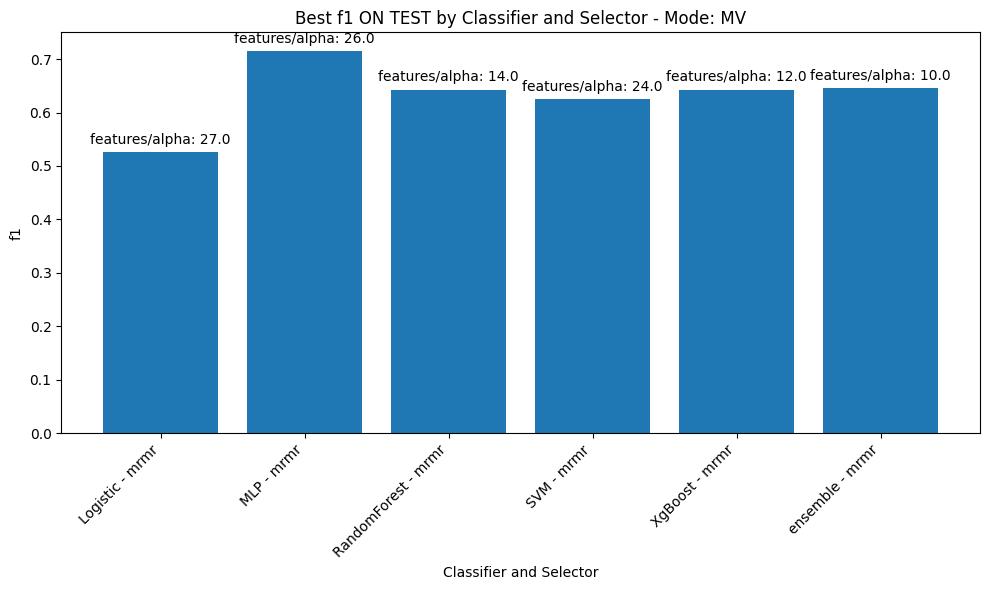

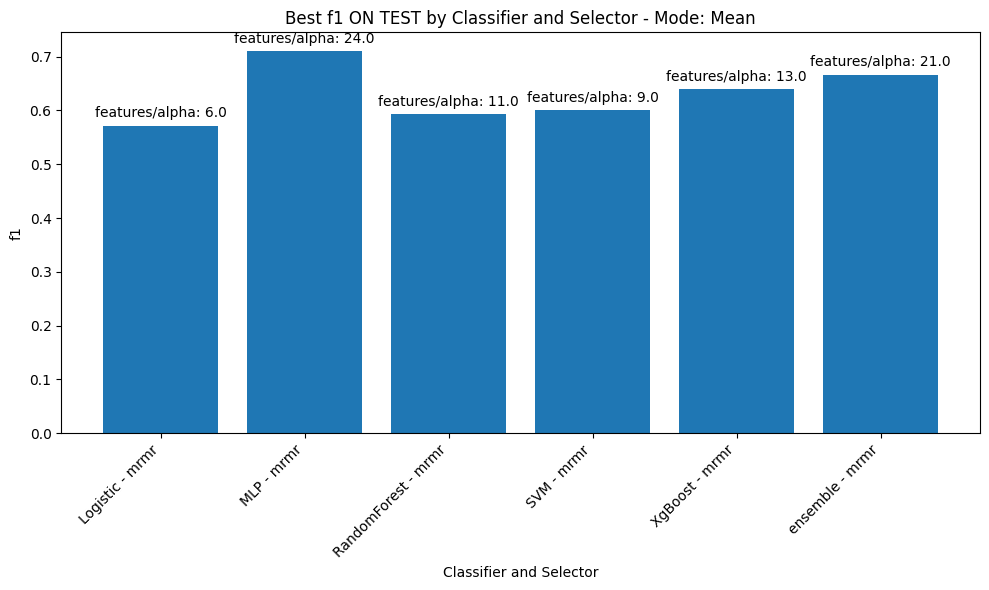

In [98]:

# Convert to DataFrame
df = pd.DataFrame(results_test)

# Assuming df is already loaded with your results

# Filter by mode and selector 'mrmr', and select the best f1 for each classifier and selector
def get_best_results_by_mode(mode, df):
    # Filter by mode and selector = 'mrmr'
    mode_df = df[(df['mode'] == mode) & (df['selector'] == 'mrmr')]
    best_results = mode_df.loc[mode_df.groupby(['classifier', 'selector'])['f1'].idxmax()]
    return best_results

# Get the best results for both modes 'MV' and 'Mean', and only where selector='mrmr'
best_results_mv = get_best_results_by_mode('MV', df)
best_results_mean = get_best_results_by_mode('Mean', df)

# Create a plot for each mode
def plot_best_results(best_results, mode):
    fig, ax = plt.subplots(figsize=(10, 6))
    labels = []
    f1_values = []
    features_or_alpha_values = []
    
    for index, row in best_results.iterrows():
        label = f"{row['classifier']} - {row['selector']}"
        features_or_alpha = row['alpha'] if row['selector'] == 'lasso' else row['num_features']
        labels.append(label)
        f1_values.append(row['f1'])
        features_or_alpha_values.append(features_or_alpha)
    
    ax.bar(labels, f1_values)
    ax.set_title(f"Best f1 ON TEST by Classifier and Selector - Mode: {mode}")
    ax.set_xlabel("Classifier and Selector")
    ax.set_ylabel("f1")
    
    # Annotate the bars with the number of features/alpha
    for i, val in enumerate(f1_values):
        ax.text(i, val + 0.01, f"features/alpha: {features_or_alpha_values[i]}", ha='center', va='bottom')

    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Plot for MV mode with selector 'mrmr'
plot_best_results(best_results_mv, 'MV')

# Plot for Mean mode with selector 'mrmr'
plot_best_results(best_results_mean, 'Mean')



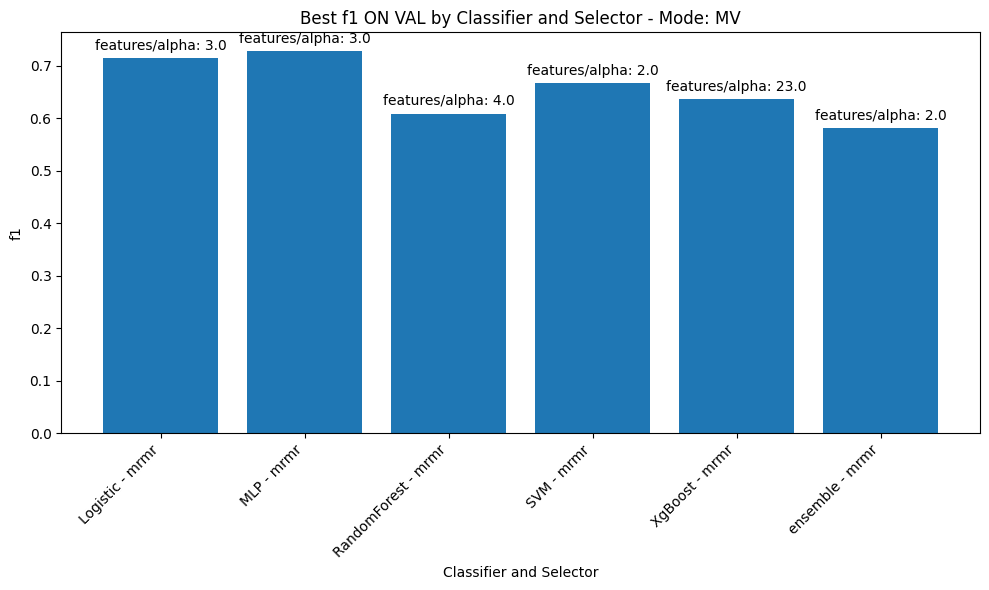

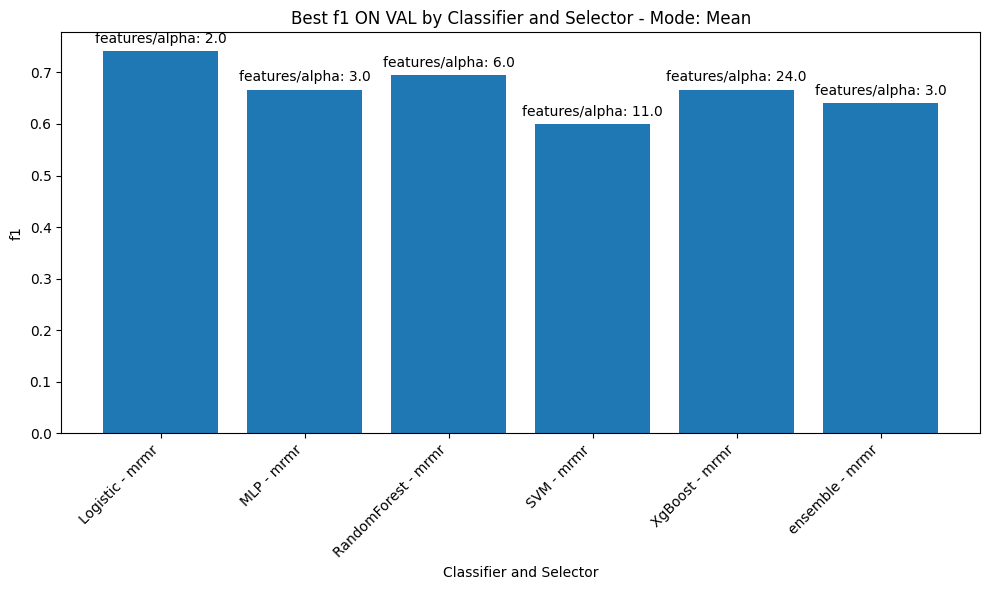

In [99]:

# Convert to DataFrame
df = pd.DataFrame(results_val)

# Assuming df is already loaded with your results

# Filter by mode and selector 'mrmr', and select the best f1 for each classifier and selector
def get_best_results_by_mode(mode, df):
    # Filter by mode and selector = 'mrmr'
    mode_df = df[(df['mode'] == mode) & (df['selector'] == 'mrmr')]
    best_results = mode_df.loc[mode_df.groupby(['classifier', 'selector'])['f1'].idxmax()]
    return best_results

# Get the best results for both modes 'MV' and 'Mean', and only where selector='mrmr'
best_results_mv = get_best_results_by_mode('MV', df)
best_results_mean = get_best_results_by_mode('Mean', df)

# Create a plot for each mode
def plot_best_results(best_results, mode):
    fig, ax = plt.subplots(figsize=(10, 6))
    labels = []
    f1_values = []
    features_or_alpha_values = []
    
    for index, row in best_results.iterrows():
        label = f"{row['classifier']} - {row['selector']}"
        features_or_alpha = row['alpha'] if row['selector'] == 'lasso' else row['num_features']
        labels.append(label)
        f1_values.append(row['f1'])
        features_or_alpha_values.append(features_or_alpha)
    
    ax.bar(labels, f1_values)
    ax.set_title(f"Best f1 ON VAL by Classifier and Selector - Mode: {mode}")
    ax.set_xlabel("Classifier and Selector")
    ax.set_ylabel("f1")
    
    # Annotate the bars with the number of features/alpha
    for i, val in enumerate(f1_values):
        ax.text(i, val + 0.01, f"features/alpha: {features_or_alpha_values[i]}", ha='center', va='bottom')

    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Plot for MV mode with selector 'mrmr'
plot_best_results(best_results_mv, 'MV')

# Plot for Mean mode with selector 'mrmr'
plot_best_results(best_results_mean, 'Mean')



### mostra per ogni classificatore, mode e selector = mrmr il risultato migliore per val e lo applica al test

In [107]:
# Step 1: Get the best results from results_val where selector is 'mrmr'
def get_best_results_from_val(results_val):
    best_results = {}
    
    # Loop through the dictionary and find the best f1 score for each classifier and mode
    for result in results_val:
        if result['selector'] == 'mrmr':
            classifier = result['classifier']
            mode = result['mode']
            key = (classifier, mode)
            
            # Check if this is the first occurrence of this classifier-mode pair
            if key not in best_results:
                best_results[key] = result
            else:
                # Compare current f1 score with the best one so far
                if result['f1'] > best_results[key]['f1']:
                    best_results[key] = result
    
    return best_results

# Step 2: Find corresponding results in results_test using the best results from results_val
def get_corresponding_test_results(best_results, results_test):
    corresponding_results = []
    
    # Loop through the best validation results
    for key, best_val in best_results.items():
        classifier = best_val['classifier']
        mode = best_val['mode']
        num_features = best_val['num_features']
        
        # Loop through results_test to find matching entries
        for test_result in results_test:
            if (test_result['classifier'] == classifier and
                test_result['mode'] == mode and
                test_result['num_features'] == num_features and
                test_result['selector'] == 'mrmr'):
                corresponding_results.append((best_val, test_result))
    
    return corresponding_results

# Step 3: Execute the functions
best_val_results = get_best_results_from_val(results_val)
corresponding_test_results = get_corresponding_test_results(best_val_results, results_test)

# Step 4: Print the corresponding results with specific fields
for val_result, test_result in corresponding_test_results:
    print("Selector:", val_result['selector'])
    print("Classifier:", val_result['classifier'])
    print("Num Features:", val_result['num_features'])
    print("Mode:", val_result['mode'])
    print("\nValidation Metrics:")
    print(" - F1 Score:", val_result['f1'])
    print(" - ROC AUC:", val_result['roc_auc'])
    print(" - PR AUC:", val_result['pr_auc'])
    print(" - accuracy:", val_result['accuracy'])
    print(" - Confusion Matrix:") 
    print(f"{val_result['confusion_matrix']}")
    print("\nTest Metrics:")
    print(" - F1 Score:", test_result['f1'])
    print(" - ROC AUC:", test_result['roc_auc'])
    print(" - PR AUC:", test_result['pr_auc'])
    print(" - accuracy:", test_result['accuracy'])
    print(" - Confusion Matrix:") 
    print(f"{test_result['confusion_matrix']}")
    print("\n" + "="*50 + "\n")


Selector: mrmr
Classifier: RandomForest
Num Features: 6
Mode: Mean

Validation Metrics:
 - F1 Score: 0.6956521739130435
 - ROC AUC: 0.7055555555555556
 - PR AUC: 0.700436312564459
 - accuracy: 0.7407407407407407
 - Confusion Matrix:
[[12  3]
 [ 4  8]]

Test Metrics:
 - F1 Score: 0.42857142857142855
 - ROC AUC: 0.6728395061728395
 - PR AUC: 0.4361239272423483
 - accuracy: 0.5897435897435898
 - Confusion Matrix:
[[17 10]
 [ 6  6]]


Selector: mrmr
Classifier: Logistic
Num Features: 2
Mode: Mean

Validation Metrics:
 - F1 Score: 0.7407407407407407
 - ROC AUC: 0.8
 - PR AUC: 0.7596416254310991
 - accuracy: 0.7407407407407407
 - Confusion Matrix:
[[10  5]
 [ 2 10]]

Test Metrics:
 - F1 Score: 0.4444444444444444
 - ROC AUC: 0.5493827160493827
 - PR AUC: 0.37071069317784455
 - accuracy: 0.48717948717948717
 - Confusion Matrix:
[[11 16]
 [ 4  8]]


Selector: mrmr
Classifier: XgBoost
Num Features: 24
Mode: Mean

Validation Metrics:
 - F1 Score: 0.6666666666666666
 - ROC AUC: 0.6333333333333333


### f1 per val e test nel caso mgiliore ma con il variare di num_features

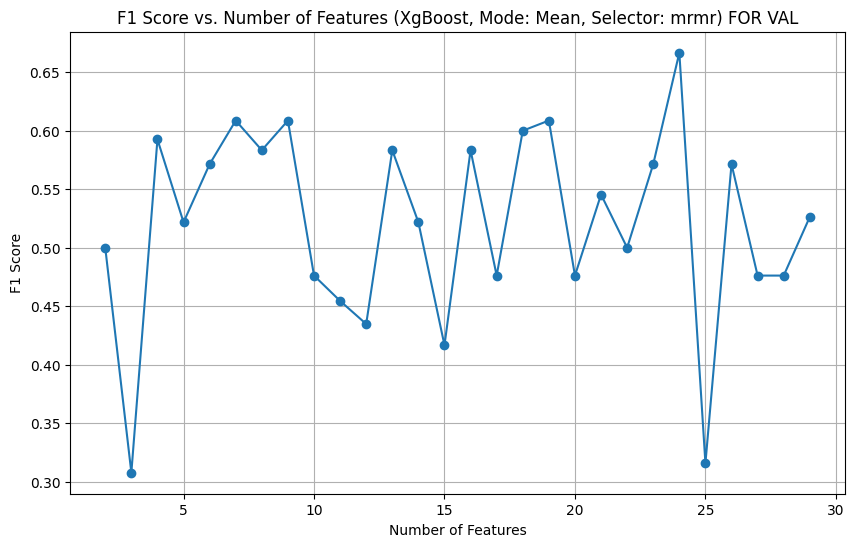

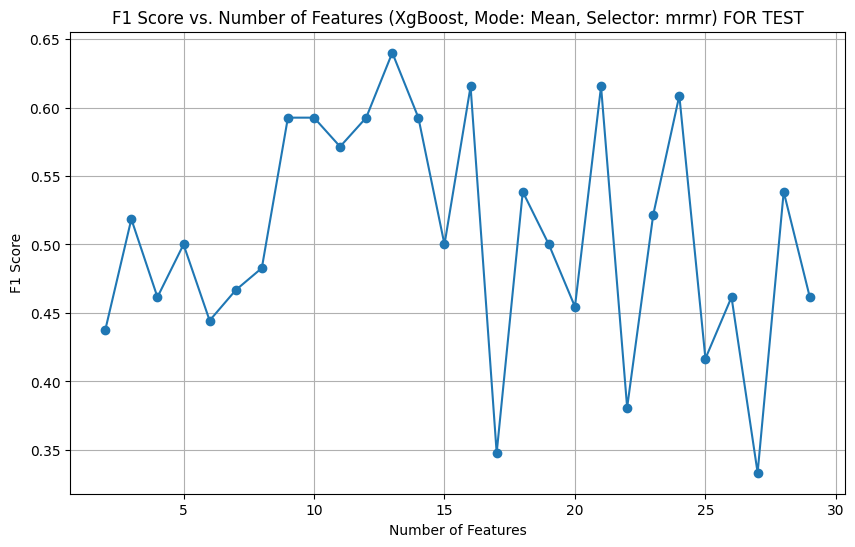

In [109]:

# Filter results_val to focus on 'XgBoost' classifier, 'Mean' mode, and 'mrmr' selector
def get_f1_by_num_features(results_val):
    f1_scores = []
    num_features_list = []
    
    # Loop through the dictionary to find the relevant entries
    for result in results_val:
        if (result['classifier'] == 'XgBoost' and
            result['mode'] == 'Mean' and
            result['selector'] == 'mrmr'):
            f1_scores.append(result['f1'])
            num_features_list.append(result['num_features'])
    
    return num_features_list, f1_scores

# Fetch data (you would pass in your actual results_val dictionary here)
num_features_list, f1_scores = get_f1_by_num_features(results_val)

# Plot F1 score against number of features
plt.figure(figsize=(10, 6))
plt.plot(num_features_list, f1_scores, marker='o')
plt.title("F1 Score vs. Number of Features (XgBoost, Mode: Mean, Selector: mrmr) FOR VAL")
plt.xlabel("Number of Features")
plt.ylabel("F1 Score")
plt.grid(True)
plt.show()

num_features_list, f1_scores = get_f1_by_num_features(results_test)

# Plot F1 score against number of features
plt.figure(figsize=(10, 6))
plt.plot(num_features_list, f1_scores, marker='o')
plt.title("F1 Score vs. Number of Features (XgBoost, Mode: Mean, Selector: mrmr) FOR TEST")
plt.xlabel("Number of Features")
plt.ylabel("F1 Score")
plt.grid(True)
plt.show()


### plotto la ROC nel caso migliore

In [ ]:


def classification_method_new(selector, alpha, classifier, x_train_expanded, y_train_expanded, patients_test, y_test, features_test, num_features, modePrediction, thresholds=np.arange(0.001, 0.501, 0.001), mode = "Val", selected_features= [0]):

    if(mode == "Val"):
            selected_features = None 
            
            if num_features != len(x_train_expanded[0]) or alpha != 0:
                if selector == "lasso":
                    X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
                elif selector == "logistic": 
                    X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
                elif selector == "mrmr":
                    X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
                elif selector == "rf":
                    X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
                elif selector=="p_value":
                    X_selected, selected_features= p_value_feature_selection(x_train_expanded,y_train_expanded, num_features)
                else:
                    print("Wrong selector. Choose between: mrmr, rf, logistic, p_value, lasso")
                    return
                
                features_test = filter_patients_features(features_test, selected_features)
            else:
                X_selected = x_train_expanded
                selected_features = list(range(len(x_train_expanded[0])))  # Selezioniamo tutte le feature se non si fa feature selection
            number_features = len(selected_features) 
        
            smote = SMOTE(random_state=42)
            #adasyn = ADASYN(random_state=42)

            X_resampled, y_resampled = smote.fit_resample(X_selected, y_train_expanded)
            classifier.fit(X_resampled, y_resampled)
   
    if (mode == "Test"): ## non si effettua nuovamente il training e la feature selection
        features_test = filter_patients_features(features_test, selected_features)
        number_features = len(selected_features)

  
    temp_array = []
    patient_scores = []
    
    for x in range(len(patients_test)):
        patient_predictions = []
        patient_predictions1 = []
        r=len(features_test[x])
        for i in range(r):
            dato = features_test[x][i].reshape(1, -1)
            prediction = classifier.predict_proba(dato)
            prediction1 = classifier.predict_proba(dato)[:,1]
            patient_predictions.append(prediction)
            patient_predictions1.append(prediction1)
            mean=np.mean(patient_predictions1)

        patient_scores.append(mean) ## contiene la media delle probabilità
        temp_array.append(patient_predictions) ## contiene tutte le probabilità
        
    best_f1_score = 0
    best_threshold = None
    best_precision=0
    best_recall=0
    best_prediction=[]
    
    # Valuta le performance utilizzando diverse threshold
    if isinstance(thresholds, (int, float, complex)):
        thresholds=[thresholds]

    ## se non viene specificato usi il parametro di default 
    ## viene calcolata la threshold che porta a un f1 migliore e effettuata la prediction con quella
    if(len(thresholds)!=1):
        for threshold in thresholds:
            binary_predictions = prob_to_binary(temp_array, patient_scores, threshold, modePrediction)
            f1 = f1_score(y_test, binary_predictions)
            if f1 > best_f1_score:
                best_f1_score = f1
                best_threshold = threshold
                best_precision = precision_score(y_test, binary_predictions)
                best_recall = recall_score(y_test, binary_predictions)
                best_prediction=binary_predictions

    else: ## qui vuol dire che è il set di test che usa la threshold migliore che viene passata dal validation
        best_threshold = thresholds
        best_prediction=prob_to_binary(temp_array, patient_scores, best_threshold, modePrediction)
        best_f1_score = f1_score(y_test, best_prediction)
        best_precision = precision_score(y_test, best_prediction)
        best_recall = recall_score(y_test, best_prediction)

    #print(f"La migliore threshold è {best_threshold} con f1score di {best_f1_score} e precision {best_precision} e recall {best_recall}.")
    y_test= np.array(y_test)
    best_prediction=np.array(best_prediction)
    test_accuracy = accuracy_score(y_test, best_prediction)
    fpr, tpr, _ = roc_curve(y_test, patient_scores)
    roc_auc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(y_test, patient_scores) ## utili per ricostruire grafici
    pr_auc = average_precision_score(y_test, patient_scores)

    #fpr, tpr, _ = roc_curve(y_test, best_prediction)
    roc_auc= roc_auc_score(y_test, patient_scores)


    conf= confusion_matrix(y_test, best_prediction)
    return best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, best_threshold, number_features, selected_features, classifier, fpr, tpr




In [113]:
classi=XGBClassifier(random_state=42)

best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc_val, bt, _, selected_features, _, fpr_val, tpr_val= classification_method_new(
                                        'mrmr', 0, classi, x_train_expanded, y_train_expanded, 
                                        patients_val, y_val, final_patients_val, 24, 'Mean', thresholds=0.5
                                   )

classi=XGBClassifier(random_state=42)

best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc_test, bt, number_features, selected_features, _, fpr_test, tpr_test = classification_method_new(
                                        'mrmr', 0, classi, x_train_expanded1, y_train_expanded1, 
                                        patients_test, y_test, final_patients_test, 24, 'Mean', thresholds=0.5
                                   )



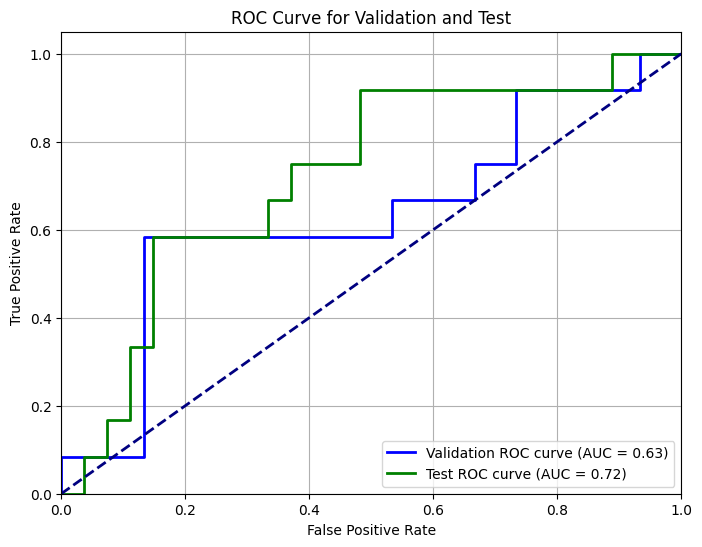

In [114]:


# Assuming you already have the FPR, TPR, and AUC values from both validation and test results

# First plot for Validation ROC curve
def plot_roc_curve(fpr_val, tpr_val, roc_auc_val, fpr_test, tpr_test, roc_auc_test):
    plt.figure(figsize=(8, 6))

    # Plot Validation ROC Curve
    plt.plot(fpr_val, tpr_val, color='blue', lw=2, label=f'Validation ROC curve (AUC = {roc_auc_val:.2f})')
    
    # Plot Test ROC Curve
    plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
    
    # Plot baseline
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    # Configure plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Validation and Test')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Example of calling the plot_roc_curve function with validation and test data
plot_roc_curve(fpr_val, tpr_val, roc_auc_val, fpr_test, tpr_test, roc_auc_test)
